In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
train_ds, test_ds = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)

In [ ]:
def prepare_cifar10_data(cifar10, batch_size, shuffle_buffer_size):
  #convert data from uint8 to float32
  cifar10 = cifar10.map(lambda img, target: (tf.cast(img, tf.float32), target))
  #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
  cifar10 = cifar10.map(lambda img, target: ((img/128.)-1., target))
  #create one-hot targets
  cifar10 = cifar10.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  #cache this progress in memory, as there is no need to redo it; it is deterministic after all
  cifar10 = cifar10.cache()
  #shuffle, batch, prefetch
  cifar10 = cifar10.shuffle(shuffle_buffer_size)
  cifar10 = cifar10.batch(batch_size)
  cifar10 = cifar10.prefetch(20)
  #return preprocessed dataset
  return cifar10

train_dataset = prepare_cifar10_data(train_ds, 24,1000) #ändern!!!
test_dataset = prepare_cifar10_data(test_ds, 24,1000)


In [ ]:
class CNNModel(tf.keras.Model):

  def __init__(self):
    super(CNNModel, self).__init__()
    self.convlayer1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
    self.convlayer2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
    self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

    self.convlayer3 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
    self.convlayer4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
    self.global_pool = tf.keras.layers.GlobalAvgPool2D()

    self.out = tf.keras.layers.Dense(10, activation='softmax')

  @tf.function
  def call(self, inputs):
      x = self.convlayer1(inputs)
      x = self.convlayer2(x)
      x = self.pooling(x)

      x = self.convlayer3(x)
      x = self.convlayer4(x)
      x = self.global_pool(x)
      x = self.out(x)
      return x

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    #new
    sample_train_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_train_accuracy = np.mean(sample_train_accuracy)
    #new end
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss , sample_train_accuracy #new

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [ ]:
#For showcasing we only use a subset of the training and test data (generally use all of the available data!)
train_dataset = train_dataset.take(1000)
test_dataset = test_dataset.take(100)

### Hyperparameters
num_epochs = 10
learning_rate = 0.1

# Initialize the model.
model = CNNModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []
train_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, train_accuracy = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with test accuracy {test_accuracies[-1]} and test loss {test_losses[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)

    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))
    print(f'Epoch: {str(epoch)} ending with train accuracy {train_accuracies[-1]} and train loss {train_losses[-1]}')


    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with test accuracy 0.08875 and test loss 2.303072452545166


In [ ]:
#For showcasing we only use a subset of the training and test data (generally use all of the available data!)
train_dataset = train_dataset.take(1000)
test_dataset = test_dataset.take(100)

### Hyperparameters
num_epochs = 10
learning_rate = 0.1

# Initialize the model.
model = CNNModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []
train_accuracies = [] #new

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss) #new
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, train_accuracy = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)#new

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}and test loss {test_losses[-1]}')

    #training (and checking in with training)
    epoch_acc_agg = [] #new
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss, train_accuracy = train_step(model, input, target, cross_entropy_loss, optimizer) #new
        epoch_loss_agg.append(train_loss)
        epoch_acc_agg.append(train_accuracy) #new


    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))
    train_accuracies.append(tf.reduce_mean(epoch_acc_agg)) #new


    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.10083333333333332and test loss 2.3044397830963135
Epoch: 1 starting with accuracy 0.3225and test loss 1.8528469800949097
Epoch: 2 starting with accuracy 0.3945833333333333and test loss 1.6581171751022339
Epoch: 3 starting with accuracy 0.45458333333333334and test loss 1.494002103805542
Epoch: 4 starting with accuracy 0.42375and test loss 1.5537561178207397
Epoch: 5 starting with accuracy 0.5420833333333333and test loss 1.2781461477279663
Epoch: 6 starting with accuracy 0.545and test loss 1.2777107954025269
Epoch: 7 starting with accuracy 0.5891666666666666and test loss 1.182794451713562


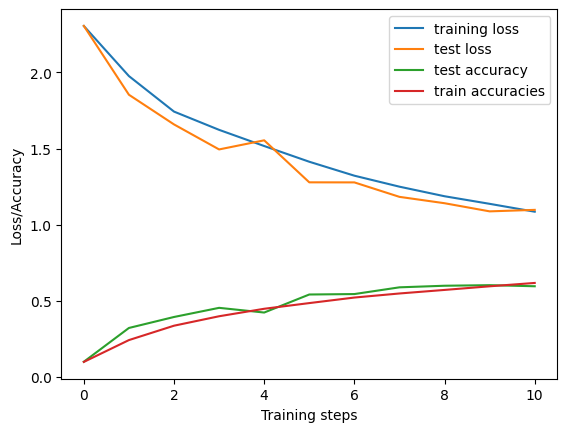

In [10]:
import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
line4, = plt.plot(train_accuracies) #new
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3, line4),("training loss","test loss", "test accuracy", "train accuracies"))
plt.show()